In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from pathlib import PurePath

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import numpy as np
import PIL.Image
import time
import functools

from keras.layers import Input, Conv2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K
import sys
import os
import numpy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Helpers from 05c UniversalStyleTransfer

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def np_to_tensor(img):
    tf.convert_to_tensor(img)

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)

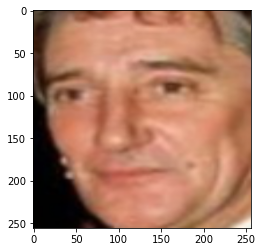

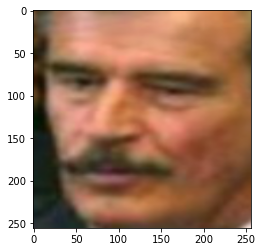

In [3]:
# Load and resize faces
def load_resize_faces():
    lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1, color=True)
    lfw_people = lfw_people.images
    lfw_people = lfw_people.astype('uint8')
    plt.imshow(lfw_people[85])
    
    resized_faces = []
    for face in lfw_people:
        img = face.astype('uint8')
        resized_faces.append(cv2.resize(img, dsize=(256,256)))

    resized_faces = np.array(resized_faces)

    img = resized_faces[85].astype('uint8')
    plt.imshow(cv2.resize(img, dsize=(256,256)))
    plt.show()

    img = resized_faces[86].astype('uint8')
    plt.imshow(cv2.resize(img, dsize=(256,256)))
    return resized_faces.astype('float32') / 255
    
resized_faces = load_resize_faces()

In [4]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer 
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image
    
        #ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        ModelBlock2 = keras.models.load_model('./TrainedModels/Block2_Model/saved_model.pb', compile=False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution 
        #ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        ModelBlock1 = keras.models.load_model('./TrainedModels/Block1_Model/saved_model.pb', compile=False)

        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.D1 = ModelBlock1.layers[1] # Trained decoder from VGG
        self.O1 = ModelBlock1.layers[2] # Conv layer to get to three channels, RGB image
        

    def call(self, image, alphas=None, training  = False):
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)
        
        style_image = image['style']
        content_image = image['content']
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        x = content_image
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        wct = self.wct_from_cov 
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
        
        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(), a_s.numpy(), alpha=alphas['layer3'])
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (blended3, reconst3)
        
        # ------Layer 2----------
        # apply whiten/color on layer 2 from the already blended image
        # get activations
        a_c = self.E2(tf.constant(x))
        a_s = self.E2(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer2'])
        # decode the new style
        x = self.O2(self.D2(x))
        x = self.enhance_contrast(x,1.3)
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended2 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (blended2, reconst2)
        
        # ------Layer 1----------
        # apply whiten/color on layer 1 from the already blended image
        # get activations
        a_c = self.E1(tf.constant(x))
        a_s = self.E1(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer1'])
        # decode the new style
        x = self.O1(self.D1(x))
        x = self.enhance_contrast(x,1.2)
        # get reconstruction
        reconst1 = self.O1(self.D1(self.E1(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended1 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (blended1, reconst1)
           
        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    @staticmethod
    def wct_from_cov(content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # applt a threshold for only the largets eigen values
        eigen_val_thresh = 1e-5
        
        # ===Whitening transform===
        # 1. take mean of each channel
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        # 2. get covariance of content, take SVD
        cov_c = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Uc, Sc, _ = np.linalg.svd(cov_c)
        # 3. truncate the SVD to only the largest eigen values
        k_c = (Sc > eigen_val_thresh).sum()
        Dc = np.diag((Sc[:k_c]+eps)**-0.5)
        Uc = Uc[:,:k_c]
        # 4. Now make a whitened content image
        fc_white = (Uc @ Dc @ Uc.T) @ fc

        # ===Coloring transform===
        # 1. take mean of each channel
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        # 2. get covariance of style, take SVD
        cov_s = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Us, Ss, _ = np.linalg.svd(cov_s)
        # 3. truncate the SVD to only the largest eigen values
        k_s = (Ss > eigen_val_thresh).sum()
        Ds = np.sqrt(np.diag(Ss[:k_s]+eps))
        Us = Us[:,:k_s]
        # 4. Now make a colored image that mixes the Grammian of the style
        #   with the whitened content image
        fcs_hat = (Us @ Ds @ Us.T) @ fc_white
        fcs_hat = fcs_hat + ms # add style mean back to each channel

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) 

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    @staticmethod
    def wct_from_signal(content, style, alpha=0.6 ):
        # This uses a more computational SVD decomposition to get the Grammian
        # to match. However, the numerical precision makes this totally fail
        # if the activations are too large. 
        # This code is only for reference based on our discussion of WCT
        
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> Cx(H*W)
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        singular_val_thresh = 1e-3
        #-------------------------------------------
        # Whitening transform and Coloring transform
        # 1. SVD of content signals
        mc = content_flat.mean()
        fc = content_flat - mc
        Uc, Sc, Vc = np.linalg.svd(fc, full_matrices=False)
        k_c = (Sc > singular_val_thresh).sum()
        
        # 2. SVD of style signals
        ms = style_flat.mean()
        fs = style_flat - ms
        Us, Ss, Vs = np.linalg.svd(fs, full_matrices=False)
        k_s = (Ss > singular_val_thresh).sum()
        
        k = min(k_s,k_c)

        # Blend transform features with original features
        fcs = (Us[:,:k] @ np.diag(Ss[:k]) @ Vc[:k,:]) + mc
        blended = alpha*fcs + (1 - alpha)*(content_flat)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)
    


In [6]:
AE = VGG19AutoEncoder('./TrainedModels')

In [7]:
# Plot an input image and the decoder output image
def plot_img_decoder_encoder(img, model):
    input_img = np.asarray(img)
    input_img = cv2.resize(input_img, dsize=(256,256))
    input_img = input_img.reshape(1, 256, 256,3)
    out_sample = model.predict(input_img)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(out_sample[0].astype(int), 0, 255))
    print(np.mean(np.square(out_sample - input_img)))
    plt.show()

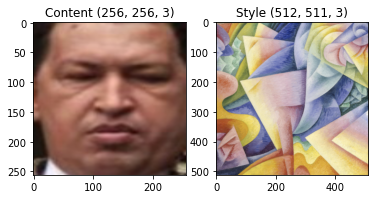

In [8]:

style_path = './mosaic_style.png'

content_image = resized_faces[80]
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

CPU times: user 6.73 s, sys: 753 ms, total: 7.49 s
Wall time: 1.31 s


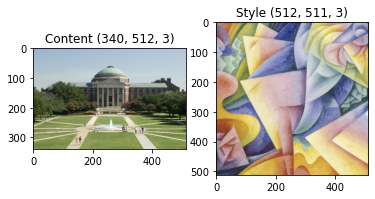

In [11]:
%%time

from skimage.transform import resize

content_path = './dallas_hall.jpg'
style_path = './mosaic_style.png'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

tmp = {'style':style_image, 
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, alphas=alphas)

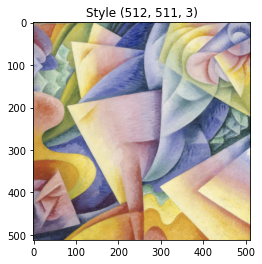

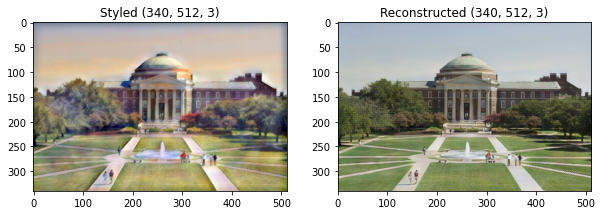

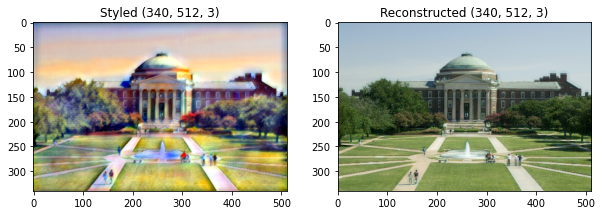

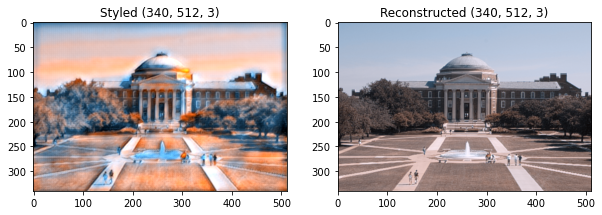

In [12]:
imshow(style_image,'Style')
for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],'Styled')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],'Reconstructed')

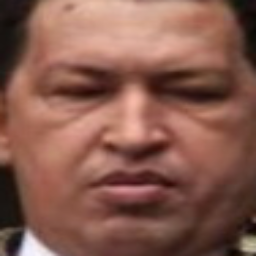

In [22]:
tf.keras.preprocessing.image.array_to_img(resized_faces[80])

CPU times: user 5.42 s, sys: 271 ms, total: 5.7 s
Wall time: 1.24 s


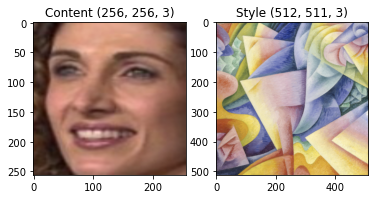

In [38]:
%%time

from skimage.transform import resize

#content_path = './dallas_hall.jpg'
style_path = './mosaic_style.png'

#content_image = load_img(content_path)
content_image = resized_faces[81].reshape((1,
                                          resized_faces[80].shape[0],
                                          resized_faces[80].shape[1],
                                          resized_faces[80].shape[2]))

content_image = tf.convert_to_tensor(content_image, dtype='float32')
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

tmp = {'style':style_image, 
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, alphas=alphas)

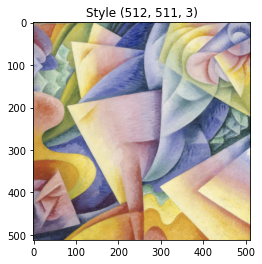

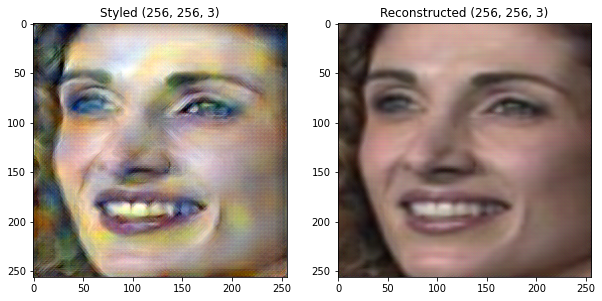

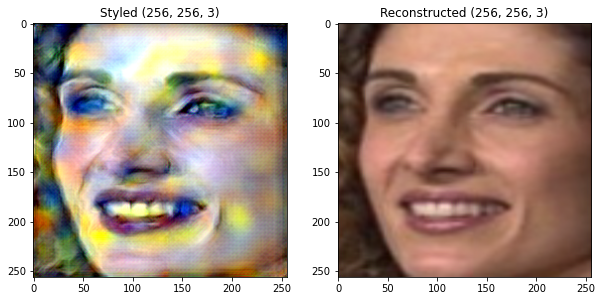

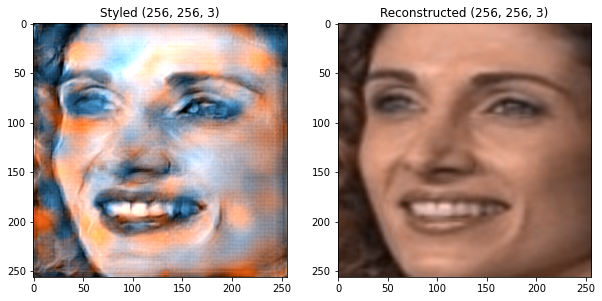

In [39]:
imshow(style_image,'Style')
for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],'Styled')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],'Reconstructed')